In [1]:
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import dask.dataframe as dd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score,roc_curve,recall_score,classification_report,mean_squared_error,confusion_matrix
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import lightgbm as lgb
from contextlib import contextmanager
import time
import threading
import random
from sklearn.model_selection import train_test_split as model_tts

In [2]:
dtyp = {'ip': np.int64, 'app': np.int16,'device': np.int16,'os': np.int16,'channel': np.int16,'is_attributed' : np.int16}

In [3]:
print("LOADING DATA..........................")
# TRAINING DATA
print("TRAINING DATA")

dfTrain = pd.read_csv("D:/train.csv/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv", nrows=100000)
#need to skip 0th row as it is the header
dfTest = pd.read_csv("D:/train.csv/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv", skiprows=range(1, 100000), nrows=100000)

print("Loading Completed")

LOADING DATA..........................
TRAINING DATA
Loading Completed


In [4]:
print("original dataframe")
dfTrain.head()

dfTest.head()

original dataframe


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,39889,12,1,20,245,2017-11-06 16:01:48,NaN,0
1,109567,8,1,19,140,2017-11-06 16:01:48,NaN,0
2,99503,15,1,15,245,2017-11-06 16:01:48,NaN,0
3,20215,3,1,9,489,2017-11-06 16:01:48,NaN,0
4,79857,15,1,19,140,2017-11-06 16:01:48,NaN,0


In [5]:
dfTest.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,39889,12,1,20,245,2017-11-06 16:01:48,NaN,0
1,109567,8,1,19,140,2017-11-06 16:01:48,NaN,0
2,99503,15,1,15,245,2017-11-06 16:01:48,NaN,0
3,20215,3,1,9,489,2017-11-06 16:01:48,NaN,0
4,79857,15,1,19,140,2017-11-06 16:01:48,NaN,0


In [6]:
dfTrain.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [7]:
def cleaning_transforming(dataframe):
    #this column is completely blank
    del dataframe['attributed_time']
    # Create new features out of time. Year and month are skipped as the data is only for 4 days
    dataframe['click_time'] =  dd.to_datetime(dataframe['click_time'])

    # the given data is of 4 days. So useful data is day and hours
    dataframe['day'] = dataframe['click_time'].dt.day
    dataframe['hour'] = dataframe['click_time'].dt.hour
    del dataframe['click_time']

    dataframe.columns = ['ip', 'app', 'device', 'os','channel','is_attributed','day','hour']

    print("dataset columns",dataframe.columns)

    dataframe.astype(dtyp)
    print("\n\n=============================================================")
    print(dataframe.info())
    return dataframe


def check_true_positive_ratio(data):
    nrows = len(data)
    print("Number of rows in the dataframe: ", nrows)
    npositive = data.is_attributed.sum() #since is_attributed has either 0 or 1. 1 is for positive cases
    print("Number of positive cases are " + str(npositive))
    nnegative = nrows - npositive
    positive_ratio = np.longdouble(npositive/nrows)
    print("Positive data ratio is ", positive_ratio*100, "%")



def positive_set(dataframe):
    #nRows = len(dataframe)
    #nPos = dataframe.is_attributed.sum()
    #nNeg = nRows - nPos
    #r = np.longdouble(nPos/nRows)
    posEx = dataframe [ (dataframe['is_attributed'] == 1) ]
    #print("Number of positive data is " + str(len(posEx)) + " rows")
    return posEx


def downsampling(dataframe, posDataframe):
    nRows = len(dataframe)
    nPos = len(posDataframe)
    nNeg = nRows - nPos
    r = np.longdouble(nPos/nRows)
    #randomly shuffle the dataframe and pick negative rows with shuffling and replacement
    random_int = random.randint(1,50)
    random_state = np.random.RandomState(random_int)
    sampledNegEx =  dataframe [ (dataframe['is_attributed'] == 0) ].sample(frac=r,random_state=random_state)
    newTrainsubs = [posDataframe, sampledNegEx]
    dfTrainBal = pd.concat(newTrainsubs)
    newRows = len(dfTrainBal)
    newPos = dfTrainBal.is_attributed.sum()
    newNeg = nRows - nPos
    rr = np.longdouble(newPos/newRows)
    return dfTrainBal


def create_chunks(dataframe):
    print("Creating 10 chunks")
    #get only positive data
    pos_set = positive_set(dataframe)
    #downsample the data to get balanced chunk
    balanced_chunks = []
    for i in range(10):
        balanced_chunks.append(downsampling(dataframe, pos_set))
    
    return balanced_chunks


def draw_roc(clf, chunk):
    #building data for crossvalidation
    random_int = random.randint(1,10)
    random_state = np.random.RandomState(random_int)
    split_size = 0.3
    dTrain, dCV = model_tts(chunk, test_size=split_size, random_state=random_state, shuffle=True )
    #Get X and y
    yTrain = dTrain['is_attributed']
    xTrain = dTrain.drop('is_attributed',axis=1)
    yCV = dCV['is_attributed']
    xCV = dCV.drop('is_attributed',axis=1)
    tprs = []
    aucs = []
    result_dict = {}
    
    mean_fpr = np.linspace(0, 1, 100)
    model = clf.fit(xTrain, yTrain)
    probas_ = model.predict_proba(xCV)
    fpr, tpr, thresholds = roc_curve(yCV, probas_[:, 1])
    
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (0, roc_auc))
    result_dict["model"] = model
    result_dict["fpr"] = fpr
    result_dict["tpr"] = tpr
    result_dict["lw"] = 1
    result_dict["alpha"] = 0.3
    result_dict["roc_fold"] = 0
    result_dict["roc_auc"] = roc_auc
    #print(str(clf), str(roc_auc))
    return result_dict


def get_roc_test(model, test_data):
    yTest = test_data['is_attributed']
    xTest = test_data.drop('is_attributed',axis=1)
    tprs = []
    aucs = []
    result_dict = {}
    mean_fpr = np.linspace(0, 1, 100)
    probas_ = model.predict_proba(xTest)
    fpr, tpr, thresholds = roc_curve(yTest, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (0, roc_auc))
    result_dict["model"] = clf
    result_dict["fpr"] = fpr
    result_dict["tpr"] = tpr
    result_dict["lw"] = 1
    result_dict["alpha"] = 0.3
    result_dict["roc_fold"] = 0
    result_dict["roc_auc"] = roc_auc
    #print(str(clf), str(roc_auc))
    return result_dict

def display_accuracy(model, test_data):
    yTest = test_data['is_attributed']
    xTest = test_data.drop('is_attributed',axis=1)
    y_pred = model.predict(xTest)
    print("Model's on test set: {:.2f}".format(model.score(xTest, yTest)))

def display_confusion_matrix(model, test_data):
    yTest = test_data['is_attributed']
    xTest = test_data.drop('is_attributed',axis=1)
    y_pred = model.predict(xTest)
    confusion_matrx = confusion_matrix(yTest, y_pred)
    print(confusion_matrx)
    return confusion_matrx

def display_classification_report(model, test_data):
    yTest = test_data['is_attributed']
    xTest = test_data.drop('is_attributed',axis=1)
    y_pred = model.predict(xTest)
    print(classification_report(yTest, y_pred))



In [8]:
dfTrain = cleaning_transforming(dfTrain)
dfTest = cleaning_transforming(dfTest)

#checking true positive ratio in train data
check_true_positive_ratio(dfTrain)

# #checking true positive ratio in test data
check_true_positive_ratio(dfTest)

dfTrainBal = create_chunks(dfTrain)

print("Checking positive ratio in each chunk now")
for chunk in dfTrainBal:
    check_true_positive_ratio(chunk)
    print("===============================")

dataset columns Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'day', 'hour'], dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip               100000 non-null int64
app              100000 non-null int64
device           100000 non-null int64
os               100000 non-null int64
channel          100000 non-null int64
is_attributed    100000 non-null int64
day              100000 non-null int64
hour             100000 non-null int64
dtypes: int64(8)
memory usage: 6.1 MB
None
dataset columns Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'day', 'hour'], dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip               100000 non-null int64
app              100000 non-null int64
device           100000 non-null int64
os               100000 non-null int64
channel          100000 non-null int64
is_a

In [9]:
dfTrainBal[0] [ (dfTrainBal[0]['is_attributed'] == 0) ].head()

,ip,app,device,os,channel,is_attributed,day,hour
9620,43809,3,1,19,137,0,6,16
11334,91820,3,1,23,280,0,6,16
84933,122411,9,1,37,215,0,6,16
53920,2180,15,1,8,386,0,6,16
9903,73487,12,1,13,205,0,6,16


In [10]:
dfTrainBal[1] [ (dfTrainBal[1]['is_attributed'] == 0) ].head()


,ip,app,device,os,channel,is_attributed,day,hour
95233,30781,6,1,19,125,0,6,16
95851,32558,8,1,10,145,0,6,16
3801,93668,23,1,10,153,0,6,16
72222,94117,12,1,13,140,0,6,16
3408,115804,3,1,19,280,0,6,16


In [11]:
dfTrainBal[2] [ (dfTrainBal[2]['is_attributed'] == 0) ].head()


,ip,app,device,os,channel,is_attributed,day,hour
58192,93549,3,1,18,480,0,6,16
48507,23419,9,1,32,215,0,6,16
25581,69770,1,1,13,134,0,6,16
96902,15932,12,1,13,245,0,6,16
97579,60258,8,1,17,145,0,6,16


In [12]:
dfTrainBal[3] [ (dfTrainBal[3]['is_attributed'] == 0) ].head()

,ip,app,device,os,channel,is_attributed,day,hour
14351,171503,3,1,13,442,0,6,16
47099,66077,3,1,13,280,0,6,16
83391,95196,15,1,15,245,0,6,16
39645,73487,15,1,13,140,0,6,16
91403,16993,9,1,18,442,0,6,16


0.7303240740740741
0.78222049689441
0.749611801242236
0.8163184864012613
0.8057692307692308
0.749611801242236
0.838076923076923
0.8161538461538461
0.7631987577639753
0.8673469387755102
best auc is  0.8673469387755102
ROC curve for validation set for logistic regression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

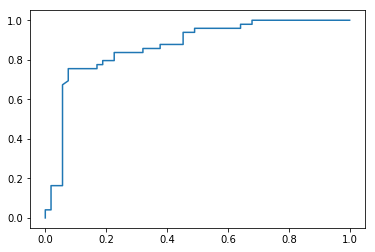

In [13]:
dTrain = pd.DataFrame()

dCV = pd.DataFrame()

best_model_lr = {}

model_list_lr = []

best_auc_lr = np.float64(0)

#building model
for chunk in dfTrainBal:
    clfLR = LogisticRegression()
    results_lr = draw_roc(clfLR, chunk)
    print(results_lr["roc_auc"])
    model_list_lr.append(results_lr)


for model in model_list_lr:
    if(np.greater(model["roc_auc"], best_auc_lr)):
        best_auc_lr = model["roc_auc"]
        best_model_lr = model

print("best auc is " , best_model_lr["roc_auc"])

print("ROC curve for validation set for logistic regression")
plt.plot(best_model_lr["fpr"], 
          best_model_lr["tpr"], best_model_lr["lw"], best_model_lr["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, best_model_lr["roc_auc"]))

In [14]:
best_model_lr["model"]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
test_lr = get_roc_test(best_model_lr["model"], dfTest)
print("best model's auc on test set for logistic regression is " , test_lr["roc_auc"])
print("ROC curve for test set for logistic regression")
plt.plot(test_lr["fpr"], 
          test_lr["tpr"], test_lr["lw"], test_lr["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, test_lr["roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()





NameError: name 'clf' is not defined

In [16]:
check_true_positive_ratio(dfTest)
dfTest = cleaning_transforming(dfTest)

Number of rows in the dataframe:  100000
Number of positive cases are 179
Positive data ratio is  0.179 %


KeyError: 'attributed_time'

In [17]:
print("Logistic Model Accuracy")
display_accuracy(best_model_lr["model"], dfTest)

Logistic Model Accuracy
Model's on test set: 0.80


In [18]:
print("Logistic Model Confusion Matrix")
confsn_matrx = display_confusion_matrix(best_model_lr["model"], dfTest)
correct_predictions = confsn_matrx[0][0] + confsn_matrx[1][1]
incorrect_predictions = confsn_matrx[0][1] + confsn_matrx[1][0]
print("Number of correct predictions: ", correct_predictions)
print("Number of incorrect predictions: ", incorrect_predictions)

Logistic Model Confusion Matrix
[[79525 20296]
 [   43   136]]
Number of correct predictions:  79661
Number of incorrect predictions:  20339


In [19]:
display_classification_report(best_model_lr["model"], dfTest)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     99821
           1       0.01      0.76      0.01       179

   micro avg       0.80      0.80      0.80    100000
   macro avg       0.50      0.78      0.45    100000
weighted avg       1.00      0.80      0.89    100000



0.8344230769230768
0.8295454545454546
0.8835194455140547
0.24344135802469133
0.7454755487100501
0.7731641676278354
0.8613785136696187
0.8295454545454546
0.8171153846153847
0.8632445141065831
best auc is  0.8632445141065831
ROC curve for validation set for support vector machine with linear kernel


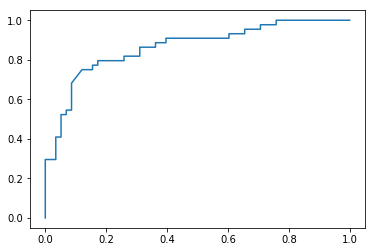

In [21]:
#building model for support vector machine with linear kernel
dTrain = pd.DataFrame()

dCV = pd.DataFrame()

split_size = 0.3
best_model_svm = {}
model_list_svm = []
best_auc_svm = np.float64(0)

#building model
for chunk in dfTrainBal:
    random_int = random.randint(1,10)
    random_state = np.random.RandomState(random_int)
    #building data for crossvalidation
    dTrain, dCV = model_tts(chunk, test_size=split_size, random_state=random_state, shuffle=True )
    #Get X and y
    yTrain = dTrain['is_attributed']
    xTrain = dTrain.drop('is_attributed',axis=1)
    yCV = dCV['is_attributed']
    xCV = dCV.drop('is_attributed',axis=1)
    clfSVM = svm.SVC(kernel='linear', probability=True,random_state=random_state)
    results_svm = draw_roc(clfSVM, chunk)
    model_list_svm.append(results_svm)
    print(results_svm["roc_auc"])

for model in model_list_svm:
    if(np.greater(model["roc_auc"], best_auc_svm)):
        best_auc_lr = model["roc_auc"]
        best_model_svm = model

print("best auc is " , best_model_svm["roc_auc"])
print("ROC curve for validation set for support vector machine with linear kernel")
plt.plot(best_model_svm["fpr"], 
          best_model_svm["tpr"], best_model_svm["lw"], best_model_svm["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, best_model_svm["roc_auc"]))


In [22]:
best_model_svm["model"]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True,
  random_state=<mtrand.RandomState object at 0x00000000060CD360>,
  shrinking=True, tol=0.001, verbose=False)

In [23]:
#Testing best model for svm with linear kernel
test_svm = get_roc_test(best_model_svm["model"], dfTest)
print("best model's auc on test set for svm with linear kernel is " , test_svm["roc_auc"])
print("ROC curve for test set for svm with linear kernel")
plt.plot(test_svm["fpr"], 
          test_svm["tpr"], test_svm["lw"], test_svm["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, test_svm["roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

NameError: name 'clf' is not defined

In [24]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)

best model's auc on test set for svm with linear kernel is  0.8241043646898899
ROC curve for test set for svm with linear kernel


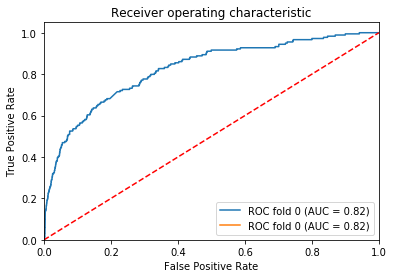

In [25]:
#Testing best model for svm with linear kernel
test_svm = get_roc_test(best_model_svm["model"], dfTest)
print("best model's auc on test set for svm with linear kernel is " , test_svm["roc_auc"])
print("ROC curve for test set for svm with linear kernel")
plt.plot(test_svm["fpr"], 
          test_svm["tpr"], test_svm["lw"], test_svm["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, test_svm["roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [26]:
#diplaying accuracy of svm with linear kernel
print("SVM Model Accuracy")
display_accuracy(best_model_svm["model"], dfTest)

SVM Model Accuracy
Model's on test set: 0.59


In [27]:
#printing model's confusion matrix for svm
print("SVM Model Confusion Matrix")
confsn_matrx = display_confusion_matrix(best_model_svm["model"], dfTest)
correct_predictions = confsn_matrx[0][0] + confsn_matrx[1][1]
incorrect_predictions = confsn_matrx[0][1] + confsn_matrx[1][0]
print("Number of correct predictions: ", correct_predictions)
print("Number of incorrect predictions: ", incorrect_predictions)

SVM Model Confusion Matrix
[[59340 40481]
 [   25   154]]
Number of correct predictions:  59494
Number of incorrect predictions:  40506


In [28]:
display_classification_report(best_model_svm["model"], dfTest)

              precision    recall  f1-score   support

           0       1.00      0.59      0.75     99821
           1       0.00      0.86      0.01       179

   micro avg       0.59      0.59      0.59    100000
   macro avg       0.50      0.73      0.38    100000
weighted avg       1.00      0.59      0.74    100000



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

0.46938775510204084
0.5092592592592593
0.5
0.5
0.5
0.5
0.5108695652173914
0.5089285714285714
0.5
0.5
best auc is  0.5108695652173914
ROC curve for validation set for support vector machine with gaussian kernel


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


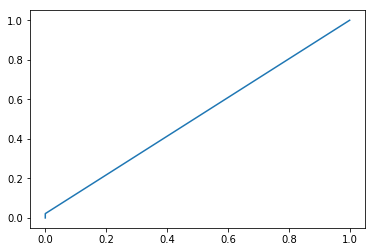

In [29]:
dTrain = pd.DataFrame()

dCV = pd.DataFrame()

split_size = 0.3
best_model_svm_gk = {}
model_list_svm_gk = []
best_auc_svm_gk = np.float64(0)

#building model
for chunk in dfTrainBal:
    random_int = random.randint(1,10)
    random_state = np.random.RandomState(random_int)
    #building data for crossvalidation
    dTrain, dCV = model_tts(chunk, test_size=split_size, random_state=random_state, shuffle=True )
    #Get X and y
    yTrain = dTrain['is_attributed']
    xTrain = dTrain.drop('is_attributed',axis=1)
    yCV = dCV['is_attributed']
    xCV = dCV.drop('is_attributed',axis=1)
    clfSVM = svm.SVC(kernel='rbf', probability=True,random_state=random_state)
    results_svm_gk = draw_roc(clfSVM, chunk)
    model_list_svm_gk.append(results_svm_gk)
    print(results_svm_gk["roc_auc"])

for model in model_list_svm_gk:
    if(np.greater(model["roc_auc"], best_auc_svm_gk)):
        best_auc_svm_gk = model["roc_auc"]
        best_model_svm_gk = model

print("best auc is " , best_model_svm_gk["roc_auc"])
print("ROC curve for validation set for support vector machine with gaussian kernel")
plt.plot(best_model_svm_gk["fpr"], 
          best_model_svm_gk["tpr"], best_model_svm_gk["lw"], best_model_svm_gk["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, best_model_svm_gk["roc_auc"]))




In [30]:
best_model_svm_gk["model"]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True,
  random_state=<mtrand.RandomState object at 0x000000000CF79480>,
  shrinking=True, tol=0.001, verbose=False)

best model's auc on test set for svm with gaussian kernel is  0.49841215776239467
ROC curve for test set for svm with gaussian kernel


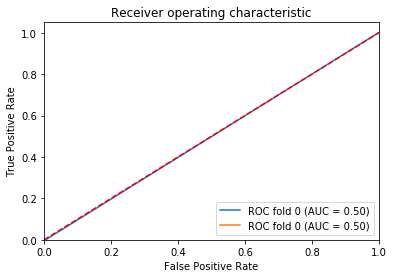

In [31]:

#Testing best model for SVM with Gaussian Kernel
test_svm_gk = get_roc_test(best_model_svm_gk["model"], dfTest)
print("best model's auc on test set for svm with gaussian kernel is " , test_svm_gk["roc_auc"])
print("ROC curve for test set for svm with gaussian kernel")
plt.plot(test_svm_gk["fpr"], 
          test_svm_gk["tpr"], test_svm_gk["lw"], test_svm_gk["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, test_svm_gk["roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()



0.9355769230769231
0.9274068322981367
0.9066230265691182
0.8966114747785908
0.8335262345679011
0.876929012345679
0.8477508650519031
0.9170196380438969
0.9195900670082775
0.8567858515955401
best auc is  0.9355769230769231
ROC curve for validation set for random forest


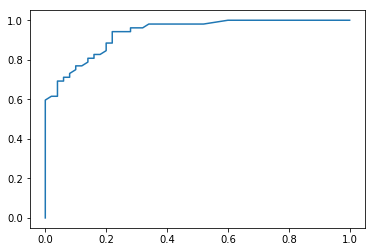

In [36]:
#building model with random forest
dTrain = pd.DataFrame()

dCV = pd.DataFrame()

split_size = 0.3
best_model_rf = {}
model_list_rf = []
best_auc_rf = np.float64(0)

#building model
for chunk in dfTrainBal:
    random_int = random.randint(1,10)
    random_state = np.random.RandomState(random_int)
    #building data for crossvalidation
    dTrain, dCV = model_tts(chunk, test_size=split_size, random_state=random_state, shuffle=True )
    #Get X and y
    yTrain = dTrain['is_attributed']
    xTrain = dTrain.drop('is_attributed',axis=1)
    yCV = dCV['is_attributed']
    xCV = dCV.drop('is_attributed',axis=1)
    clfRF = RandomForestClassifier(n_estimators=100,random_state=random_state)
    results_rf = draw_roc(clfRF, chunk)
    model_list_rf.append(results_rf)
    print(results_rf["roc_auc"])

for model in model_list_rf:
    if(np.greater(model["roc_auc"], best_auc_rf)):
        best_auc_rf = model["roc_auc"]
        best_model_rf = model

print("best auc is " , best_model_rf["roc_auc"])
print("ROC curve for validation set for random forest")
plt.plot(best_model_rf["fpr"], 
          best_model_rf["tpr"], best_model_rf["lw"], best_model_rf["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, best_model_rf["roc_auc"]))



In [37]:
best_model_rf["model"]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False,
            random_state=<mtrand.RandomState object at 0x000000000D03E5A0>,
            verbose=0, warm_start=False)

best model's auc on test set for random forest is  0.9152074391932509
ROC curve for test set for random forest


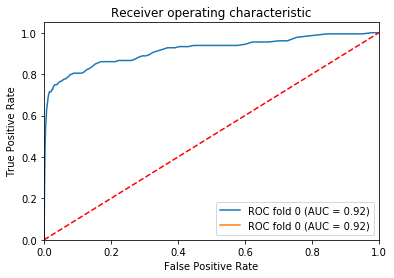

In [38]:
test_rf = get_roc_test(best_model_rf["model"], dfTest)
print("best model's auc on test set for random forest is " , test_rf["roc_auc"])
# #print(dTrain.head())
print("ROC curve for test set for random forest")
plt.plot(test_rf["fpr"], 
          test_rf["tpr"], test_rf["lw"], test_rf["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, test_rf["roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [39]:
#diplaying accuracy of random forest
print("Random Forest Accuracy")
display_accuracy(best_model_rf["model"], dfTest)


Random Forest Accuracy
Model's on test set: 0.86


In [40]:
#printing model's confusion matrix for random forest
print("Random Forest Confusion Matrix")
confsn_matrx = display_confusion_matrix(best_model_rf["model"], dfTest)
correct_predictions = confsn_matrx[0][0] + confsn_matrx[1][1]
incorrect_predictions = confsn_matrx[0][1] + confsn_matrx[1][0]
print("Number of correct predictions: ", correct_predictions)
print("Number of incorrect predictions: ", incorrect_predictions)

Random Forest Confusion Matrix
[[85354 14467]
 [   29   150]]
Number of correct predictions:  85504
Number of incorrect predictions:  14496


In [41]:
display_classification_report(best_model_rf["model"], dfTest)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     99821
           1       0.01      0.84      0.02       179

   micro avg       0.86      0.86      0.86    100000
   macro avg       0.50      0.85      0.47    100000
weighted avg       1.00      0.86      0.92    100000



positive cases in training set:  0.18717 %

number of positive cases are 18717
Number of positive rows  18717
Number of rows selected randomly in sampled negative dataset :  18682
Number of rows in balanced dataset  37399
positive cases in training set:  50.04679269499185 %

number of positive cases are 18717


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.956486	valid's auc: 0.945553
[100]	train's auc: 0.961768	valid's auc: 0.947986
Early stopping, best iteration is:
[76]	train's auc: 0.960513	valid's auc: 0.948135
[train with valid] done in 1 s
Plotting feature importances...


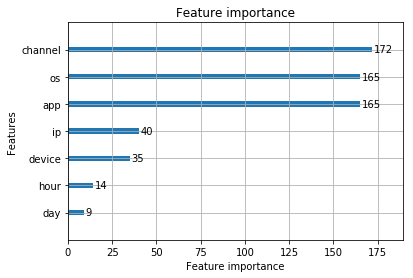

array([0.80514394, 0.99243427, 0.51244711, ..., 0.65421958, 0.98777801,
       0.98549045])

In [48]:
#train_df=dfTrain
train_df = pd.read_csv("D:/train.csv/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv", nrows=10000000)
train_df['click_time'] = pd.to_datetime(train_df['click_time'])
train_df['attributed_time'] = pd.to_datetime(train_df['attributed_time'])

train_df['hour'] = train_df.click_time.dt.hour.astype('uint8')
train_df['day'] = train_df.click_time.dt.day.astype('uint8')
train_df.drop(['attributed_time'], axis=1, inplace=True)
train_df.drop(['click_time'], axis=1, inplace=True)

train_df = down_sampling(train_df)

@contextmanager
def timer(name):
    t0=time.time()
    yield
    print(f'[{name}] done in {time.time()-t0:.0f} s')

VALIDATE = False
RANDOM_STATE = 50
VALID_SIZE = 0.30
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 650
skiprows = range(1,134903891)
nrows = 50000000

target = 'is_attributed'
predictors = ['ip', 'app','device','os', 'channel', 'day', 'hour']
categorical = ['ip', 'app', 'device', 'os', 'channel', 'day', 'hour']

train_df, val_df = model_tts(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.1,
          'num_leaves': 9,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 5,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':200, # because training data is extremely unbalanced 
          'num_threads':32
         }
dtrain = lgb.Dataset(train_df[predictors].values, 
                             label=train_df[target].values,
                             feature_name=predictors,
                             categorical_feature=categorical)

dvalid = lgb.Dataset(val_df[predictors].values,
                             label=val_df[target].values,
                             feature_name=predictors,
                             categorical_feature=categorical)
evals_result = {}
with timer('train with valid'):
    model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid], 
                          valid_names=['train','valid'], 
                          evals_result=evals_result, 
                          num_boost_round=MAX_ROUNDS,
                          early_stopping_rounds=EARLY_STOP,
                          verbose_eval=50, 
                          feval=None)
        

print('Plotting feature importances...')
lgb.plot_importance(model, max_num_features=30)
plt.show()


# In[164]:


test_data = dfTest
yTest = test_data['is_attributed']
xTest = test_data.drop('is_attributed',axis=1)

pred = model.predict(xTest, num_iteration=model.best_iteration)
pred
